# To get the results of the TFM
---

- https://doi.org/10.2307/2290328 (train_test_split : 0.75)

In [9]:
# To use the operating system functionalities.
import os

# To store properly params.
import json

# To use arrays.
import numpy as np

# To make plots.
import matplotlib.pyplot as plt
import seaborn as sns

# To store and dump models.
import joblib

# To make random samples and seed.
import random as rnd

# To treat with times.
import time

# ML libraries.
from sklearn.model_selection import (learning_curve, KFold)
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor)
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import lightgbm as lgb

from typing import (List, Dict, Tuple, Optional, Union, Any, Callable)

# To treat dataframes.
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Own libraries.
from edafecomp import initialization_eda_fe
from utils import (timing_decorator, DataLoader, DataFrameOptimizer, PathStorage)
from modelling import (Metricas, DataPreparationToModelNew)
from eda import (full_EdaNew, EdaNew)
from fe import full_FeatureEngineeringNew
from parallel_try import (plot_feature_importance, timeit_decorator_with_pid)

# To dont need to restart kernel.
%load_ext autoreload
%autoreload 2

# To dont show output of the cell.
from IPython.display import clear_output
clear_output()

In [2]:
HYPERPARAMETERS = {
    'mes_default' : 24,
    'mes_a_predecir' : 36,
    'semilla' : 42,
    'n_jobs' : 16,
    'tipo_de_model' : 'random_forest',
    'modelos' : ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'],
    'ruta_de_mejores_modelos_joblibs' : PathStorage().DIR_MODELS_JOBLIBS,
    'ruta_de_mejores_modelos_parametros_json' : PathStorage().DIR_PARAMETERS_JSONS,
    'ruta_study_optuna' : PathStorage().DIR_STUDY_OPTUNA,  
    'ruta_guardar_imagenes' : PathStorage().DIR_IMAGES,
    'ruta_guardar_metricas' : PathStorage().DIR_METRICS,
    }

Compruebo si existen las rutas de guardado

In [3]:
print(os.path.exists(HYPERPARAMETERS['ruta_de_mejores_modelos_joblibs']))
print(os.path.exists(HYPERPARAMETERS['ruta_de_mejores_modelos_parametros_json']))
print(os.path.exists(HYPERPARAMETERS['ruta_study_optuna']))

True
True
True


In [4]:
# Asegurarse de que las rutas existen o crearlas
for ruta in [HYPERPARAMETERS['ruta_de_mejores_modelos_joblibs'], HYPERPARAMETERS['ruta_de_mejores_modelos_parametros_json'], HYPERPARAMETERS['ruta_study_optuna']]:
    os.makedirs(ruta, exist_ok=True)

Proceso general del TFM

In [5]:
def cargar_datos_mas_eda_fe(mes_a_predecir = 24):

    data_loader = DataLoader() 
    dict_of_dfs : Dict[str, pd.DataFrame] = {}

    dict_of_dfs['proteins'], dict_of_dfs['peptides'], dict_of_dfs['clinical'], _ = data_loader.load_train_data()

    month_to_filter = mes_a_predecir

    df_proteins = dict_of_dfs['proteins']
    df_peptides = dict_of_dfs['peptides']
    df_clinical = dict_of_dfs['clinical']

    # Dataframe filtered by month.
    proteins_filtered_by_month = EdaNew.filter_proteins_by_month(df_proteins, month_to_filter=month_to_filter)
    peptides_filtered_by_month = EdaNew.filter_peptides_by_month(df_peptides, month_to_filter=month_to_filter)
    clinical_filtered_by_month = EdaNew.filter_clinical_by_month(df_clinical, month_to_filter=month_to_filter)

    # Merging the normal three entry dataframes.
    proteins_peptides_merged_month_24 = pd.merge(peptides_filtered_by_month, proteins_filtered_by_month, how='left', on=['visit_id', 'visit_month', 'patient_id', 'UniProt'])
    df_merged_all = pd.merge(proteins_peptides_merged_month_24, clinical_filtered_by_month, how='left', on=['visit_id', 'patient_id', 'visit_month'])

    # Removing duplicates (Also you can analyze or visualize).
    df_merged_all_filtered_by_duplicates = EdaNew.analyze_and_visualize_duplicates(df_merged_all, verbose=False)

    # Remove null values.
    df_merged_filtered_by_nullsand_duplicates = EdaNew.calculate_and_remove_null_values(df_merged_all_filtered_by_duplicates, verbose=False)

    #
    df_merged_all_filtered_without_ouliers_iqr = EdaNew.remove_outliers_iqr(df_merged_filtered_by_nullsand_duplicates)

    #
    df_merged_all_filtered_with_log_column = EdaNew.add_log_columns(df_merged_all_filtered_without_ouliers_iqr)

    # 
    df_merged_all_filtered_without_ouliers_iqr = EdaNew.remove_outliers_iqr(df_merged_all_filtered_with_log_column)

    #
    df_merged_all_filtered_full_Eda = EdaNew.remove_outliers_std(df_merged_all_filtered_without_ouliers_iqr)

    # 
    df_merged_all_filtered_full_Eda = EdaNew.drop_null_count(df_merged_all_filtered_full_Eda)

    #
    df_merged_all_filtered_full_Eda = EdaNew.drop_upd23b_clinical_state_on_medication(df_merged_all_filtered_full_Eda)

    #
    df_merged_all_filtered_full_Eda = EdaNew.drop_visit_id_and_visit_month(df_merged_all_filtered_full_Eda)

    df_after_eda = df_merged_all_filtered_full_Eda

    df_after_fe = full_FeatureEngineeringNew(df_after_eda) # TODO

    # data_to_models = df_after_fe.drop(columns=['patient_id', 'UniProt', 'Peptide'], axis=1) # TODO

    data_to_models = df_after_fe

    train_results = [data_to_models.drop(columns=[f'updrs_{j}' for j in range(1, 5) if j != i]) for i in range(1, 5)]

    return train_results

def datos_divididos_y_normalizad(datos_para_el_entrenamiento, prediccion = False, validacion = False):

    print(validacion)
    processed_data = []
    
    for df, target_column in zip(datos_para_el_entrenamiento, HYPERPARAMETERS['modelos']):
        print(f'Processing {target_column}')

        if validacion == True:
            # Dividir los datos
            X = df.drop(target_column, axis=1)
            y = df[target_column]

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=HYPERPARAMETERS['semilla']) # 80% train, 20% test
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=HYPERPARAMETERS['semilla']) # 64% train, 16% val = 80% train

        elif validacion == False:
            # Dividir los datos
            X = df.drop(target_column, axis=1)
            y = df[target_column]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=HYPERPARAMETERS['semilla'])
            
        # Normalizar los datos
        scaler = MinMaxScaler()
        X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

        if validacion == True:
                print("Estoy validando.")
                X_val_norm = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
        
        X_test_norm = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

        # Almacenar datos normalizados y objetivos en una estructura de datos
        
        if validacion == True:
            processed_data.append({
                'X_train': X_train_norm,
                'X_val': X_val_norm,
                'X_test': X_test_norm,
                'y_train': y_train,
                'y_val': y_val,
                'y_test': y_test
                })
            
        elif validacion == False:
            processed_data.append({
                'X_train': X_train_norm,
                'X_val': None,
                'X_test': X_test_norm,
                'y_train': y_train,
                'y_val': None,
                'y_test': y_test
                })

        # Guardar los datos procesados# Opcional: Puedes imprimir las formas de los conjuntos de datos para verificar.
        print(f"X_train shape: {processed_data[0]['X_train'].shape}")
        if validacion == True:
            print(f"X_val shape: {processed_data[0]['X_val'].shape}")
        print(f"X_test shape: {processed_data[0]['X_test'].shape}")

    return processed_data

def entrenamiento_desde_cero_sin_joblibs_ni_json(processed_data):

    # Crear un diccionario para almacenar los modelos
    models = {}

    # Crear un diccionario para almacenar los errores
    errors_mae = {}
    errors_rmse = {}
    errors_smape = {}

    for i, data in enumerate(processed_data):
        
        # Crear el modelo
        if HYPERPARAMETERS['tipo_de_model'] == 'random_forest':
            model = RandomForestRegressor(n_estimators=100, random_state=HYPERPARAMETERS['semilla'], n_jobs=HYPERPARAMETERS['n_jobs'])
            
        # Entrenar el modelo
        model.fit(data['X_train'], data['y_train'])
        # Guardar el modelo
        models[f'model_{i+1}'] = model
        # Predecir los objetivos en el conjunto de prueba
        y_pred = model.predict(data['X_test'])
        # Calcular el error
        error_smape = Metricas.smape(data['y_test'], y_pred)
        error_rmse = mean_squared_error(data['y_test'], y_pred, squared=False)
        error_mae = mean_squared_error(data['y_test'], y_pred)
        # Guardar el error
        errors_smape[f'model_{i+1}'] = error_smape
        errors_rmse[f'model_{i+1}'] = error_rmse
        errors_mae[f'model_{i+1}'] = error_mae
        # Imprimir el error

    print(f"Error (metrica : smape) de los modelos: {errors_smape}")
    print(f"Error (metrica : rmse) de los modelos: {errors_rmse}")
    print(f"Error (metrica : mae) de los modelos: {errors_mae}")

    return models, errors_mae, errors_rmse, errors_smape

def full_tratar_datos(mes, entrenar_modelos = False, prediccion = False, validacion = False):

    print(validacion)
    
    # Cargar datos
    datos_para_el_entrenamiento = cargar_datos_mas_eda_fe(mes_a_predecir=mes)

    print(validacion)

    # Dividir y normalizar datos
    processed_data = datos_divididos_y_normalizad(datos_para_el_entrenamiento, validacion = validacion)

    if entrenar_modelos:
        # Entrenar modelos
        models, errors_mae, errors_rmse, errors_smape = entrenamiento_desde_cero_sin_joblibs_ni_json(processed_data)
        return models, errors_mae, errors_rmse, errors_smape

    else:
        # Porque asi solo tendras datos tratados que despues usare para hacer predicciones.
        return processed_data

# Opcion A: Random Forest (n_estimators=100)

In [6]:
models_24_opcion_a, errors_mae_opcion_a, errors_rmse_opcion_a, errors_smape_opcion_a = full_tratar_datos(mes=HYPERPARAMETERS['mes_default'], entrenar_modelos=True, validacion=False)

False
False
False
False
Processing updrs_1
X_train shape: (60937, 41)
X_test shape: (15235, 41)
Processing updrs_2
X_train shape: (60937, 41)
X_test shape: (15235, 41)
Processing updrs_3
X_train shape: (60937, 41)
X_test shape: (15235, 41)
Processing updrs_4
X_train shape: (60937, 41)
X_test shape: (15235, 41)
Error (metrica : smape) de los modelos: {'model_1': 44.39784797585503, 'model_2': 43.24151560205719, 'model_3': 33.70640703971758, 'model_4': 137.48977658124818}
Error (metrica : rmse) de los modelos: {'model_1': 4.923549017968064, 'model_2': 4.772135235894258, 'model_3': 10.489122561315435, 'model_4': 3.1120757012811366}
Error (metrica : mae) de los modelos: {'model_1': 24.241334932334283, 'model_2': 22.77327470966355, 'model_3': 110.02169210629646, 'model_4': 9.68501517050448}


Verificamos la media de los smapes

In [7]:
# Voy a calcular la media de los smapes
smapes_opcion_a = []
for i in range(1, 5):
    smapes_opcion_a.append(errors_smape_opcion_a[f'model_{i}'])
# la media de los smapes
smapes_opcion_a = np.mean(smapes_opcion_a)

rmse_opcion_a = []
for i in range(1, 5):
    rmse_opcion_a.append(errors_rmse_opcion_a[f'model_{i}'])
# la media de los rmse
rmse_opcion_a = np.mean(rmse_opcion_a)

mae_opcion_a = []
for i in range(1, 5):
    mae_opcion_a.append(errors_mae_opcion_a[f'model_{i}'])
# la media de los mae
mae_opcion_a = np.mean(mae_opcion_a)

print(f"Error (metrica : smape) de los modelos: {errors_smape_opcion_a}")
print(f"La media de los smapes es: {smapes_opcion_a}")
print(f"Error (metrica : rmse) de los modelos: {errors_rmse_opcion_a}")
print(f"La media de los rmse es: {rmse_opcion_a}")
print(f"Error (metrica : mae) de los modelos: {errors_mae_opcion_a}")
print(f"La media de los mae es: {mae_opcion_a}")

Error (metrica : smape) de los modelos: {'model_1': 44.39784797585503, 'model_2': 43.24151560205719, 'model_3': 33.70640703971758, 'model_4': 137.48977658124818}
La media de los smapes es: 64.7088867997195
Error (metrica : rmse) de los modelos: {'model_1': 4.923549017968064, 'model_2': 4.772135235894258, 'model_3': 10.489122561315435, 'model_4': 3.1120757012811366}
La media de los rmse es: 5.824220629114723
Error (metrica : mae) de los modelos: {'model_1': 24.241334932334283, 'model_2': 22.77327470966355, 'model_3': 110.02169210629646, 'model_4': 9.68501517050448}
La media de los mae es: 41.680329229699694


# Opcion B: It is possible to choose all models and OPTUNA

In [8]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def create_objective(type_of_model = 'random_forest'):
    def objective(trial, X_train, X_val, y_train, y_val):

        if type_of_model == 'xgboost':
            model_params = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 100),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'gamma': trial.suggest_float('gamma', 0, 5),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 100),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
            }
            model = xgb.XGBRegressor(**model_params, random_state=HYPERPARAMETERS['semilla'], n_jobs=HYPERPARAMETERS['n_jobs'])

        elif type_of_model == 'random_forest':
            model_params = {
                'max_depth' : trial.suggest_int('max_depth', 2, 32, log=True),
                'min_samples_split' : trial.suggest_float('min_samples_split', 0.1, 1.0),
                'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10)
            }
            model = RandomForestRegressor(**model_params, n_estimators=100, random_state=HYPERPARAMETERS['semilla'], n_jobs=HYPERPARAMETERS['n_jobs'])

        elif type_of_model == 'gradient_boosting':
            model_params = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 100),
            }
            model = GradientBoostingRegressor(**model_params, random_state=HYPERPARAMETERS['semilla'])

        elif type_of_model == "lightgbm":
            model_params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'max_depth': trial.suggest_int('max_depth', -1, 15),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
                'num_leaves': trial.suggest_int('num_leaves', 20, 300),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
                'min_split_gain': trial.suggest_float('min_split_gain', 0, 1)
            }
            model = lgb.LGBMRegressor(**model_params, random_state=HYPERPARAMETERS['semilla'], n_jobs=HYPERPARAMETERS['n_jobs'])
        
        # Entrenar el modelo.
        model.fit(X_train, y_train)

        # Realizar predicciones y calcular SMAPE
        y_pred = model.predict(X_val)
        smape = Metricas.smape(y_val, y_pred)

        return smape
    return objective

def calculo_de_optuna_para_cada_modelo(processed_data, type_of_model):
    # Crear y ejecutar un estudio de Optuna para cada modelo
    for i, data in enumerate(processed_data):
        study = optuna.create_study(direction='minimize')
        objective_function = create_objective(type_of_model)
        study.optimize(lambda trial: objective_function(trial, data['X_train'], data['X_val'], data['y_train'], data['y_val']), n_trials=5)

        # Obtener los mejores hiperparámetros
        best_params = study.best_params

        # Seleccionar y reentrenar el modelo correcto con los mejores hiperparámetros
        if type_of_model == 'xgboost':
            model = xgb.XGBRegressor(**best_params, random_state=HYPERPARAMETERS['semilla'], n_jobs=HYPERPARAMETERS['n_jobs'])
        elif type_of_model == 'random_forest':
            model = RandomForestRegressor(**best_params, random_state=HYPERPARAMETERS['semilla'], n_jobs=HYPERPARAMETERS['n_jobs'])
        elif type_of_model == 'gradient_boosting':
            model = GradientBoostingRegressor(**best_params, random_state=HYPERPARAMETERS['semilla'])
        elif type_of_model == "lightgbm":
            model = lgb.LGBMRegressor(**best_params, random_state=HYPERPARAMETERS['semilla'], n_jobs=HYPERPARAMETERS['n_jobs'])

        model.fit(pd.concat([data['X_train'], data['X_val']]), pd.concat([data['y_train'], data['y_val']]))

        # Guardar el modelo
        joblib_file = os.path.join(HYPERPARAMETERS['ruta_de_mejores_modelos_joblibs'], f"{type_of_model}_model_{i+1}.joblib")
        joblib.dump(model, joblib_file)

        # Guardar los parámetros del modelo
        json_file = os.path.join(HYPERPARAMETERS['ruta_de_mejores_modelos_parametros_json'], f"{type_of_model}_params_model_{i+1}.json")
        with open(json_file, 'w') as file:
            json.dump(best_params, file)
       
        print(f"Modelo y parámetros para modelo_{i+1} guardados.")

        # Guardar el estudio de Optuna
        study_path = os.path.join(HYPERPARAMETERS['ruta_study_optuna'], f"{type_of_model}_study_model_{i+1}.pkl")
        joblib.dump(study, study_path)

        print(f"Modelo, parámetros y estudio para modelo_{i+1} guardados en {HYPERPARAMETERS['ruta_study_optuna']}.")

    return print('Optuna finalizado')

In [9]:
processed_data_opcion_b = full_tratar_datos(mes=HYPERPARAMETERS['mes_default'], entrenar_modelos=False, validacion=True)

start = time.time()
calculo_de_optuna_para_cada_modelo(processed_data_opcion_b, type_of_model = HYPERPARAMETERS['tipo_de_model'])
end = time.time()
print(f"Tiempo de ejecucion de Optuna: {end - start} segundos.")

True
False
True
True
Processing updrs_1
Estoy validando.
X_train shape: (48749, 41)
X_val shape: (12188, 41)
X_test shape: (15235, 41)
Processing updrs_2


[I 2024-01-16 19:10:01,788] A new study created in memory with name: no-name-53a0b214-75cd-44e8-ac6a-78dad1ba51e6


Estoy validando.
X_train shape: (48749, 41)
X_val shape: (12188, 41)
X_test shape: (15235, 41)
Processing updrs_3
Estoy validando.
X_train shape: (48749, 41)
X_val shape: (12188, 41)
X_test shape: (15235, 41)
Processing updrs_4
Estoy validando.
X_train shape: (48749, 41)
X_val shape: (12188, 41)
X_test shape: (15235, 41)


[I 2024-01-16 19:10:03,132] Trial 0 finished with value: 50.155702873894846 and parameters: {'max_depth': 12, 'min_samples_split': 0.1932463536714503, 'min_samples_leaf': 2}. Best is trial 0 with value: 50.155702873894846.
[I 2024-01-16 19:10:03,294] Trial 1 finished with value: 50.236832153307745 and parameters: {'max_depth': 7, 'min_samples_split': 0.7636305815072074, 'min_samples_leaf': 1}. Best is trial 0 with value: 50.155702873894846.
[I 2024-01-16 19:10:04,188] Trial 2 finished with value: 50.17360711234146 and parameters: {'max_depth': 27, 'min_samples_split': 0.33724269048888683, 'min_samples_leaf': 3}. Best is trial 0 with value: 50.155702873894846.
[I 2024-01-16 19:10:04,680] Trial 3 finished with value: 50.18294292786025 and parameters: {'max_depth': 3, 'min_samples_split': 0.5660813387418046, 'min_samples_leaf': 5}. Best is trial 0 with value: 50.155702873894846.
[I 2024-01-16 19:10:04,844] Trial 4 finished with value: 50.236832153307745 and parameters: {'max_depth': 2, 'm

Modelo y parámetros para modelo_1 guardados.
Modelo, parámetros y estudio para modelo_1 guardados en c:\TFM_FATIMA\1501_copy\fatima_tfm_150124\data\outputs\study_optuna.


[I 2024-01-16 19:10:06,549] Trial 0 finished with value: 49.15581571360509 and parameters: {'max_depth': 3, 'min_samples_split': 0.6592837497706501, 'min_samples_leaf': 9}. Best is trial 0 with value: 49.15581571360509.
[I 2024-01-16 19:10:06,713] Trial 1 finished with value: 49.15581571360509 and parameters: {'max_depth': 11, 'min_samples_split': 0.9131447917594753, 'min_samples_leaf': 2}. Best is trial 0 with value: 49.15581571360509.
[I 2024-01-16 19:10:07,986] Trial 2 finished with value: 49.0715223377974 and parameters: {'max_depth': 11, 'min_samples_split': 0.2553116848855349, 'min_samples_leaf': 9}. Best is trial 2 with value: 49.0715223377974.
[I 2024-01-16 19:10:08,474] Trial 3 finished with value: 49.125866732324006 and parameters: {'max_depth': 11, 'min_samples_split': 0.6197210547467422, 'min_samples_leaf': 2}. Best is trial 2 with value: 49.0715223377974.
[I 2024-01-16 19:10:08,631] Trial 4 finished with value: 49.15581571360509 and parameters: {'max_depth': 4, 'min_sample

Modelo y parámetros para modelo_2 guardados.
Modelo, parámetros y estudio para modelo_2 guardados en c:\TFM_FATIMA\1501_copy\fatima_tfm_150124\data\outputs\study_optuna.


[I 2024-01-16 19:10:10,895] Trial 0 finished with value: 42.026611087172135 and parameters: {'max_depth': 5, 'min_samples_split': 0.5336560281207697, 'min_samples_leaf': 4}. Best is trial 0 with value: 42.026611087172135.
[I 2024-01-16 19:10:13,381] Trial 1 finished with value: 41.83222386020946 and parameters: {'max_depth': 11, 'min_samples_split': 0.10465979408129697, 'min_samples_leaf': 1}. Best is trial 1 with value: 41.83222386020946.
[I 2024-01-16 19:10:15,553] Trial 2 finished with value: 41.91125892915134 and parameters: {'max_depth': 14, 'min_samples_split': 0.28884189155387757, 'min_samples_leaf': 7}. Best is trial 1 with value: 41.83222386020946.
[I 2024-01-16 19:10:16,608] Trial 3 finished with value: 41.98968451681237 and parameters: {'max_depth': 5, 'min_samples_split': 0.4334159987827516, 'min_samples_leaf': 2}. Best is trial 1 with value: 41.83222386020946.
[I 2024-01-16 19:10:16,774] Trial 4 finished with value: 42.03827087468493 and parameters: {'max_depth': 17, 'min_

Modelo y parámetros para modelo_3 guardados.
Modelo, parámetros y estudio para modelo_3 guardados en c:\TFM_FATIMA\1501_copy\fatima_tfm_150124\data\outputs\study_optuna.


[I 2024-01-16 19:10:20,170] Trial 1 finished with value: 144.03323131082306 and parameters: {'max_depth': 13, 'min_samples_split': 0.6725645513588304, 'min_samples_leaf': 7}. Best is trial 0 with value: 144.03323131082306.
[I 2024-01-16 19:10:20,729] Trial 2 finished with value: 144.01006551391683 and parameters: {'max_depth': 12, 'min_samples_split': 0.46068599231437046, 'min_samples_leaf': 8}. Best is trial 2 with value: 144.01006551391683.
[I 2024-01-16 19:10:20,898] Trial 3 finished with value: 144.03323131082306 and parameters: {'max_depth': 2, 'min_samples_split': 0.9392143798251497, 'min_samples_leaf': 9}. Best is trial 2 with value: 144.01006551391683.
[I 2024-01-16 19:10:21,405] Trial 4 finished with value: 144.0102484905287 and parameters: {'max_depth': 15, 'min_samples_split': 0.593980656827084, 'min_samples_leaf': 2}. Best is trial 2 with value: 144.01006551391683.


Modelo y parámetros para modelo_4 guardados.
Modelo, parámetros y estudio para modelo_4 guardados en c:\TFM_FATIMA\1501_copy\fatima_tfm_150124\data\outputs\study_optuna.
Optuna finalizado
Tiempo de ejecucion de Optuna: 20.352263927459717 segundos.


# Cargamos los modelos, parametros y studies de optuna

In [10]:
# Cargar los modelos y los parámetros.
models = {}
params = {}
studies = {}

for i in range(1, 5):
    model_path = os.path.join(HYPERPARAMETERS['ruta_de_mejores_modelos_joblibs'], f"{HYPERPARAMETERS['tipo_de_model']}_model_{i}.joblib")
    params_path = os.path.join(HYPERPARAMETERS['ruta_de_mejores_modelos_parametros_json'], f"{HYPERPARAMETERS['tipo_de_model']}_params_model_{i}.json")

    # Cargar los modelos.
    models[f'model_{i}'] = joblib.load(model_path)

    # Cargar los parámetros.
    with open(params_path, 'r') as file:
        params[f'model_{i}'] = json.load(file)

    # Cargar los estudios de Optuna.
    study_path = os.path.join(HYPERPARAMETERS['ruta_study_optuna'], f"{HYPERPARAMETERS['tipo_de_model']}_study_model_{i}.pkl")
    studies[f'model_{i}'] = joblib.load(study_path)

In [11]:
for key, values in models.items():
    print('\n')
    print(key, values)



model_1 RandomForestRegressor(max_depth=12, min_samples_leaf=2,
                      min_samples_split=0.1932463536714503, n_jobs=16,
                      random_state=42)


model_2 RandomForestRegressor(max_depth=11, min_samples_leaf=9,
                      min_samples_split=0.2553116848855349, n_jobs=16,
                      random_state=42)


model_3 RandomForestRegressor(max_depth=11, min_samples_split=0.10465979408129697,
                      n_jobs=16, random_state=42)


model_4 RandomForestRegressor(max_depth=12, min_samples_leaf=8,
                      min_samples_split=0.46068599231437046, n_jobs=16,
                      random_state=42)


# Prediccion sobre dataframe original de 24 meses.

In [12]:
# Preparar datos de entrada a modelos entrenados para predecir.

# Cargar datos 
datos_para_prediccion = cargar_datos_mas_eda_fe(mes_a_predecir=HYPERPARAMETERS['mes_default'])

# Dividir y normalizar datos
processed_data_para_predecir = datos_divididos_y_normalizad(datos_para_prediccion, validacion=False)

# Predecir los objetivos en el conjunto de prueba
y_preds = []
for i, data in enumerate(processed_data_para_predecir):
    y_preds.append(models[f'model_{i+1}'].predict(data['X_test']))

# Calcular las metricas de cada uno por separado (con sus smapes) y realizar la media total.
smapes = []
for i, data in enumerate(processed_data_para_predecir):
    smapes.append(Metricas.smape(data['y_test'], y_preds[i]))

rmse = []
for i, data in enumerate(processed_data_para_predecir):
    rmse.append(mean_squared_error(data['y_test'], y_preds[i], squared=False))

mae = []
for i, data in enumerate(processed_data_para_predecir):
    mae.append(mean_squared_error(data['y_test'], y_preds[i]))

False
False
Processing updrs_1
X_train shape: (60937, 41)
X_test shape: (15235, 41)
Processing updrs_2
X_train shape: (60937, 41)
X_test shape: (15235, 41)
Processing updrs_3
X_train shape: (60937, 41)
X_test shape: (15235, 41)
Processing updrs_4
X_train shape: (60937, 41)
X_test shape: (15235, 41)


# Prediccion sobre dataframe no visto con Joblibs y Json.

In [13]:
# Preparar datos de entrada a modelos entrenados para predecir.

# Cargar datos 

datos_para_prediccion = cargar_datos_mas_eda_fe(mes_a_predecir=HYPERPARAMETERS['mes_a_predecir'])

processed_data_no_visto = []
    
for df, target_column in zip(datos_para_prediccion, HYPERPARAMETERS['modelos']):
    print(f'Processing {target_column}')

    # Dividir los datos
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    scaler = MinMaxScaler()
    X_test_norm = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    processed_data_no_visto.append({
        'X_train': None,
        'X_val': None,
        'X_test': X_test_norm,
        'y_train': y,
        'y_val': None,
        'y_test': y
        })

# Dividir y normalizar datos
processed_data_no_visto = datos_divididos_y_normalizad(datos_para_prediccion)

# Predecir los objetivos en el conjunto de prueba
y_preds_no_visto = []
for i, data in enumerate(processed_data_no_visto):
    y_preds_no_visto.append(models[f'model_{i+1}'].predict(data['X_test']))

# Calcular las metricas de cada uno por separado (con sus smapes) y realizar la media total.
smapes_no_visto = []
for i, data in enumerate(processed_data_no_visto):
    smapes_no_visto.append(Metricas.smape(data['y_test'], y_preds_no_visto[i]))

rmse_no_visto = []
for i, data in enumerate(processed_data_no_visto):
    rmse_no_visto.append(mean_squared_error(data['y_test'], y_preds_no_visto[i], squared=False))

mae_no_visto = []
for i, data in enumerate(processed_data_no_visto):
    mae_no_visto.append(mean_squared_error(data['y_test'], y_preds_no_visto[i]))


def Predicciones_sobre_df_no_visto(mes_a_predecir):
    datos_para_prediccion = cargar_datos_mas_eda_fe(mes_a_predecir=mes_a_predecir)
    processed_data_no_visto = []
    
    for df, target_column in zip(datos_para_prediccion, HYPERPARAMETERS['modelos']):
        print(f'Processing {target_column}')

        # Dividir los datos
        X = df.drop(target_column, axis=1)
        y = df[target_column]

        # Verificar si X está vacío
        if X.shape[0] == 0:
            print(f"El conjunto de datos para {target_column} está vacío. Omitiendo.")
            continue

        scaler = MinMaxScaler()
        X_test_norm = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

        processed_data_no_visto.append({
            'X_train': None,
            'X_val': None,
            'X_test': X_test_norm,
            'y_train': y,
            'y_val': None,
            'y_test': y
        })

    # Dividir y normalizar datos
    processed_data_no_visto = datos_divididos_y_normalizad(datos_para_prediccion)

    # Predecir los objetivos en el conjunto de prueba
    y_preds_no_visto = []
    for i, data in enumerate(processed_data_no_visto):
        y_preds_no_visto.append(models[f'model_{i+1}'].predict(data['X_test']))

    # Calcular las metricas de cada uno por separado (con sus smapes) y realizar la media total.
    smapes_no_visto = []
    for i, data in enumerate(processed_data_no_visto):
        smapes_no_visto.append(Metricas.smape(data['y_test'], y_preds_no_visto[i]))

    rmse_no_visto = []
    for i, data in enumerate(processed_data_no_visto):
        rmse_no_visto.append(mean_squared_error(data['y_test'], y_preds_no_visto[i], squared=False))

    mae_no_visto = []
    for i, data in enumerate(processed_data_no_visto):
        mae_no_visto.append(mean_squared_error(data['y_test'], y_preds_no_visto[i]))

    return smapes_no_visto, rmse_no_visto, mae_no_visto

False
Processing updrs_1
Processing updrs_2
Processing updrs_3
Processing updrs_4
False
Processing updrs_1
X_train shape: (58028, 41)
X_test shape: (14508, 41)
Processing updrs_2
X_train shape: (58028, 41)
X_test shape: (14508, 41)
Processing updrs_3
X_train shape: (58028, 41)
X_test shape: (14508, 41)
Processing updrs_4
X_train shape: (58028, 41)
X_test shape: (14508, 41)


---

Sumario de los resultados

In [14]:
def sumario_metricas(mes_a_predecir, to_csv=True, type_of_model=HYPERPARAMETERS['tipo_de_model']):
    # Crear DataFrame para métricas
    modelos = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

    smapes_no_visto, rmse_no_visto, mae_no_visto = Predicciones_sobre_df_no_visto(mes_a_predecir=mes_a_predecir)

    # Suponer que las métricas están en listas
    metricas_24_meses = pd.DataFrame({'Modelo': modelos, 'SMAPE': smapes, 'RMSE': rmse, 'MAE': mae})
    metricas_no_visto = pd.DataFrame({'Modelo': modelos, 'SMAPE': smapes_no_visto, 'RMSE': rmse_no_visto, 'MAE': mae_no_visto})

    # Unificar los DataFrames
    metricas_totales = pd.concat([metricas_24_meses.assign(Dataset='24 Meses'), metricas_no_visto.assign(Dataset=f"{HYPERPARAMETERS['mes_a_predecir']} Meses")], ignore_index=True)

    # Calcular las medias solo para columnas numéricas
    medias = metricas_totales.groupby('Dataset').mean(numeric_only=True).reset_index()

    # Agregar las medias al DataFrame
    metricas_totales = pd.concat([metricas_totales, medias.assign(Modelo='Media')], ignore_index=True)

    # Ordenar el DataFrame por 'Dataset'
    metricas_totales = metricas_totales.sort_values(by='Dataset')

    # Mostrar el DataFrame
    print(metricas_totales)

    if to_csv:
        # Guardar el DataFrame como CSV
        ruta_csv = os.path.join(HYPERPARAMETERS['ruta_guardar_metricas'], f"{type_of_model}_metricas_totales_no_visto_{HYPERPARAMETERS['mes_a_predecir']}.csv")
        metricas_totales.to_csv(ruta_csv, index=False)
        print(f"Archivo CSV guardado en: {ruta_csv}")
        

In [15]:
sumario_metricas(mes_a_predecir=HYPERPARAMETERS['mes_a_predecir'], to_csv=True, type_of_model=HYPERPARAMETERS['tipo_de_model'])

False
Processing updrs_1
Processing updrs_2
Processing updrs_3
Processing updrs_4
False
Processing updrs_1
X_train shape: (58028, 41)
X_test shape: (14508, 41)
Processing updrs_2
X_train shape: (58028, 41)
X_test shape: (14508, 41)
Processing updrs_3
X_train shape: (58028, 41)
X_test shape: (14508, 41)
Processing updrs_4
X_train shape: (58028, 41)
X_test shape: (14508, 41)
    Modelo       SMAPE       RMSE         MAE   Dataset
0  updrs_1   50.119839   5.530267   30.583857  24 Meses
1  updrs_2   49.317044   5.290011   27.984214  24 Meses
2  updrs_3   41.803944  12.603931  158.859074  24 Meses
3  updrs_4  143.912139   3.511532   12.330856  24 Meses
8    Media   71.288241   6.733935   57.439500  24 Meses
4  updrs_1   57.730661   6.029235   36.351675  36 Meses
5  updrs_2   51.395753   5.619322   31.576776  36 Meses
6  updrs_3   42.929483  13.072662  170.894502  36 Meses
7  updrs_4  146.403368   3.588904   12.880231  36 Meses
9    Media   74.614816   7.077531   62.925796  36 Meses
Archivo 

In [16]:
for key, value in models.items():
    print(f"Modelo {key} con parámetros {value}")

Modelo model_1 con parámetros RandomForestRegressor(max_depth=12, min_samples_leaf=2,
                      min_samples_split=0.1932463536714503, n_jobs=16,
                      random_state=42)
Modelo model_2 con parámetros RandomForestRegressor(max_depth=11, min_samples_leaf=9,
                      min_samples_split=0.2553116848855349, n_jobs=16,
                      random_state=42)
Modelo model_3 con parámetros RandomForestRegressor(max_depth=11, min_samples_split=0.10465979408129697,
                      n_jobs=16, random_state=42)
Modelo model_4 con parámetros RandomForestRegressor(max_depth=12, min_samples_leaf=8,
                      min_samples_split=0.46068599231437046, n_jobs=16,
                      random_state=42)


---

# Graficas y resultados.

## Graficas

### Feature importance
- Cambiar colores
- tamano de letra
- rotacion de la letra
- titulo

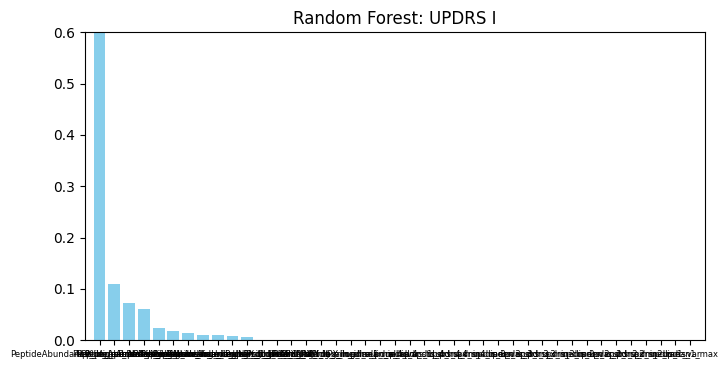

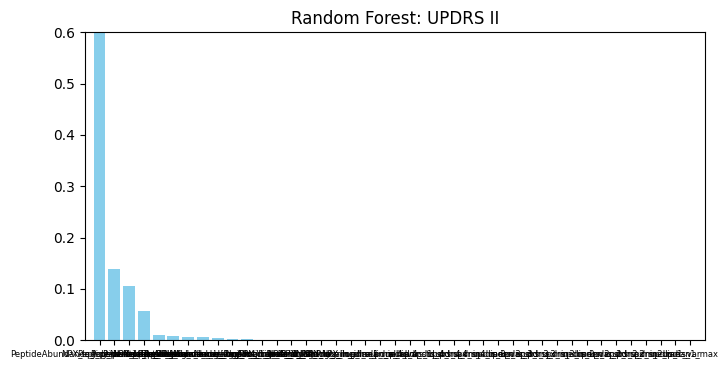

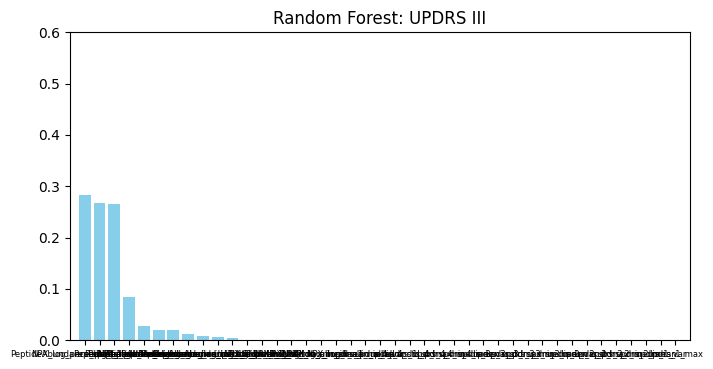

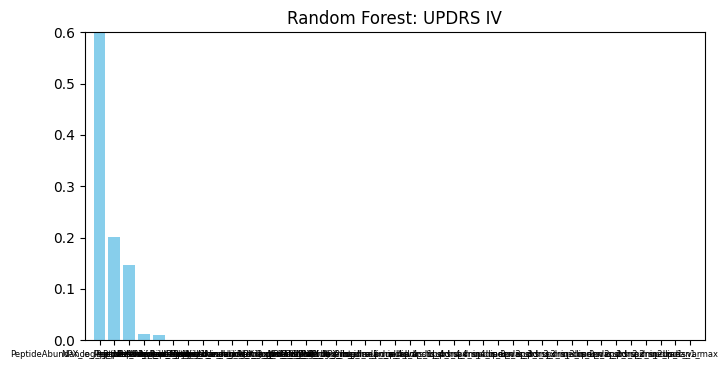

In [18]:
# Voy a sacar la grafica de Feature importance para cada uno de los modelos.

DICCIONARIO_MODELOS = {
    'random_forest' : 'Random Forest',
    'xgboost' : 'XGBoost',
    'lightgbm' : 'LightGBM',
    'gradient_boosting' : 'Gradient Boosting'
}

DICCIONARIO_UPDRS = {
    'updrs_1' : 'UPDRS I',
    'updrs_2' : 'UPDRS II',
    'updrs_3' : 'UPDRS III',
    'updrs_4' : 'UPDRS IV'
}

for i, data in enumerate(processed_data_para_predecir):
    plot_feature_importance(models[f'model_{i+1}'], data['X_train'].columns, f"{DICCIONARIO_MODELOS[HYPERPARAMETERS['tipo_de_model']]}: {DICCIONARIO_UPDRS[HYPERPARAMETERS['modelos'][i]]}")

In [19]:
def plot_feature_importance_modified(model, feature_names, title, file_name, top_n=11):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]

    # Quiero imprimir el orden de las importancias de mayor a menor.
    print(f"Importancias: {importances}")
    print(f"Indices: {indices}")
    print(f"Feature names: {feature_names}")
    print(f"Feature names indices: {[feature_names[i] for i in indices]}")

    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color='skyblue', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.savefig(file_name)
    plt.close()  # Esto es para cerrar la figura y liberar memoria
    
top_n_features = 11

for i, data in enumerate(processed_data_para_predecir):
    model_name = f"{DICCIONARIO_MODELOS[HYPERPARAMETERS['tipo_de_model']]}_{DICCIONARIO_UPDRS[HYPERPARAMETERS['modelos'][i]]}"
    file_name = os.path.join(HYPERPARAMETERS['ruta_guardar_imagenes'], f"feature_importance_{model_name}.png")
    plot_feature_importance_modified(models[f'model_{i+1}'], data['X_train'].columns, f"Feature Importance: {model_name}", file_name, top_n=top_n_features)


Importancias: [0.06044892 0.01443436 0.10988876 0.07280433 0.         0.
 0.         0.         0.         0.         0.66405801 0.01122833
 0.0174546  0.00679778 0.02479911 0.00813553 0.00995029 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
Indices: [13 15 16 11  1 12 14  0  3  2 10]
Feature names: Index(['NPX_log', 'PeptideAbundance_log', 'Peptide_per_Protein',
       'NPX_log_percentile_in_all', 'NPX_log_mean_in_all',
       'NPX_log_median_in_all', 'NPX_log_min_in_all', 'NPX_log_max_in_all',
       'NPX_log_std_in_all', 'NPX_log_var_in_all',
       'PeptideAbundance_log_percentile_in_local',
       'PeptideAbundance_log_mean_in_UniProt',
       'PeptideAbundance_log_median_in_UniProt',
       'PeptideAbundance_log_min_in_UniProt',
       'PeptideAbundance_log_max_in_UniProt',
       'PeptideAbu

In [20]:
for i in range(1, 5):
    print(f"Modelo {i}: {len(studies[f'model_{i}'].trials_dataframe())} ensayos")

Modelo 1: 5 ensayos
Modelo 2: 5 ensayos
Modelo 3: 5 ensayos
Modelo 4: 5 ensayos


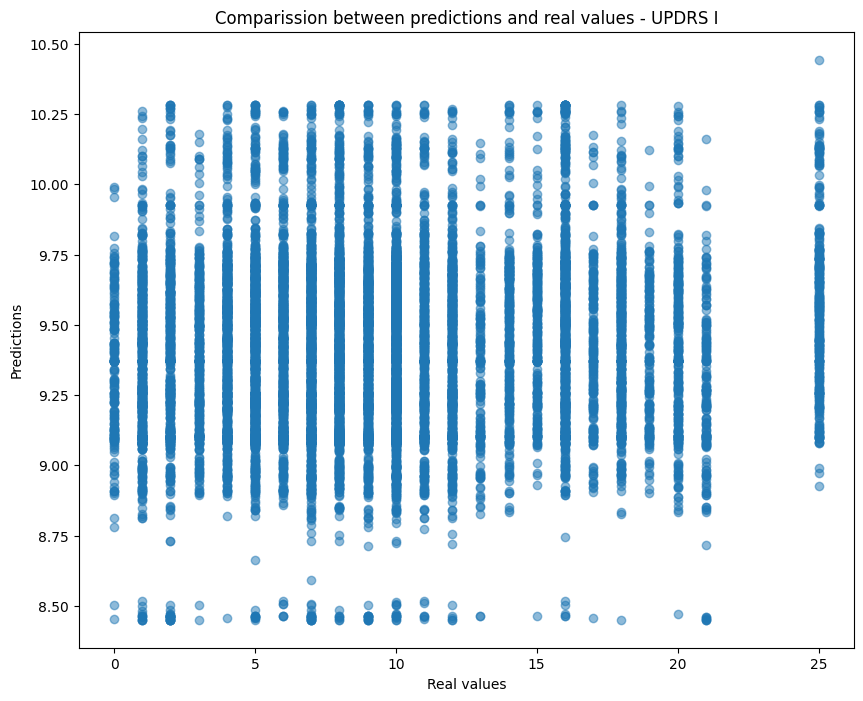

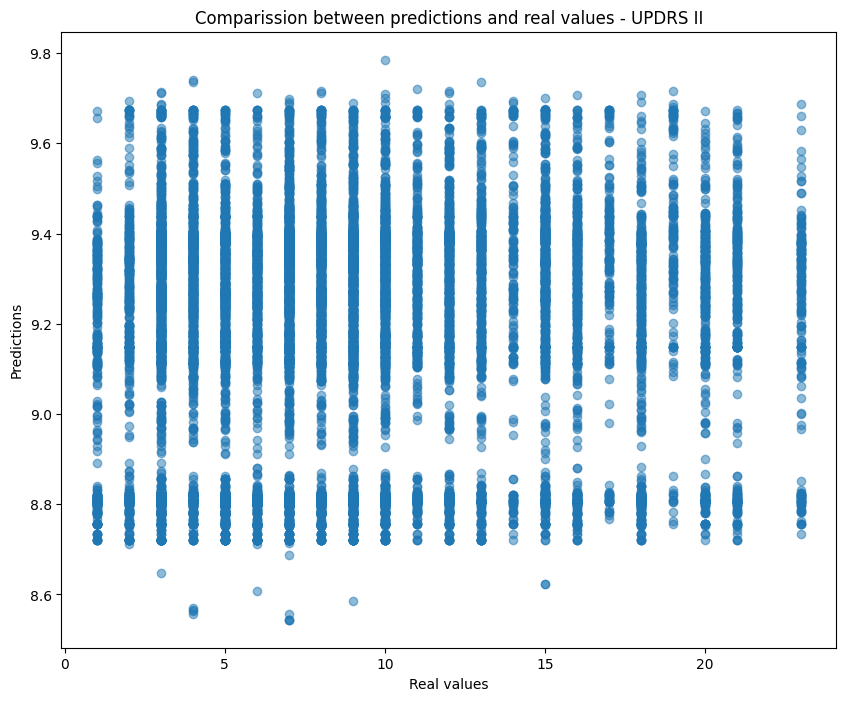

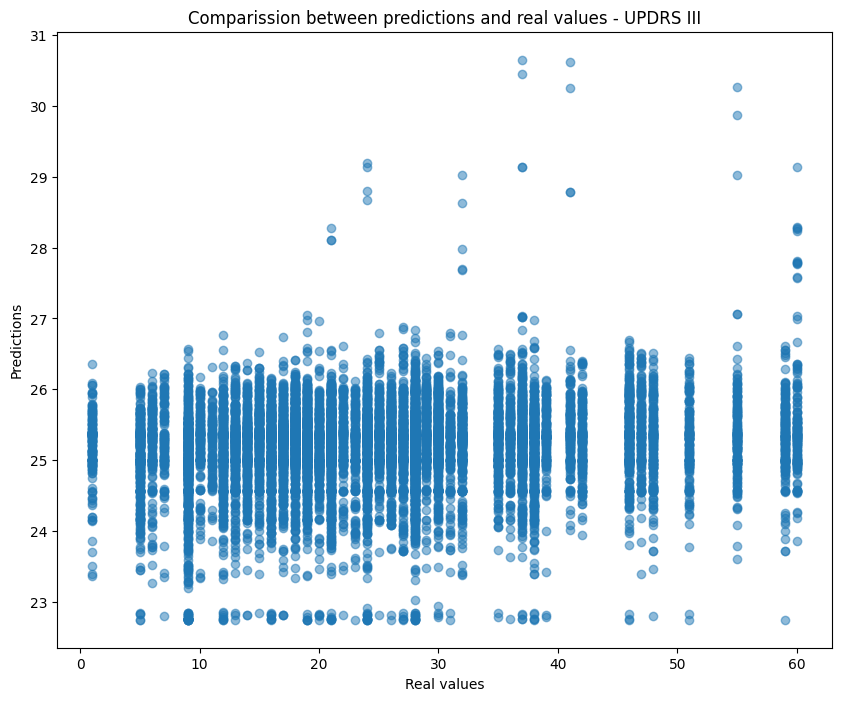

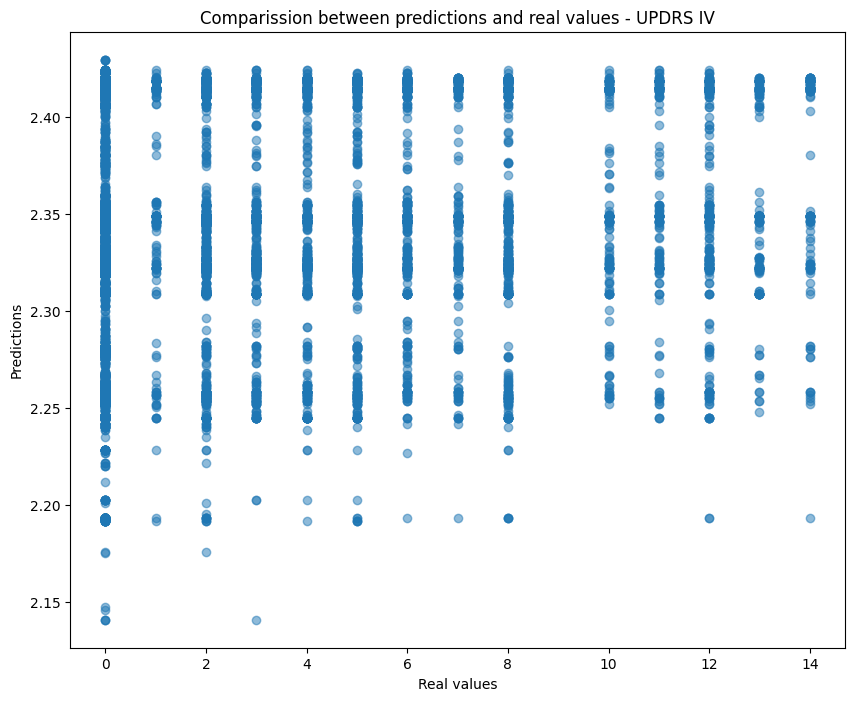

In [21]:
for i, data in enumerate(processed_data_para_predecir):
    y_pred = models[f'model_{i+1}'].predict(data['X_test'])
    plt.figure(figsize=(10, 8))
    plt.scatter(data['y_test'], y_pred, alpha=0.5)
    plt.title(f"Comparission between predictions and real values - {DICCIONARIO_UPDRS[HYPERPARAMETERS['modelos'][i]]}")
    plt.xlabel('Real values')
    plt.ylabel('Predictions')
    # plt.plot([data['y_test'].min(), data['y_test'].max()], [data['y_test'].min(), data['y_test'].max()])
    plt.savefig(os.path.join(HYPERPARAMETERS['ruta_guardar_imagenes'], f"comparacion_valores_reales_vs_predicciones_{DICCIONARIO_MODELOS[HYPERPARAMETERS['tipo_de_model']]}_{DICCIONARIO_UPDRS[HYPERPARAMETERS['modelos'][i]]}.png"))
    plt.show()

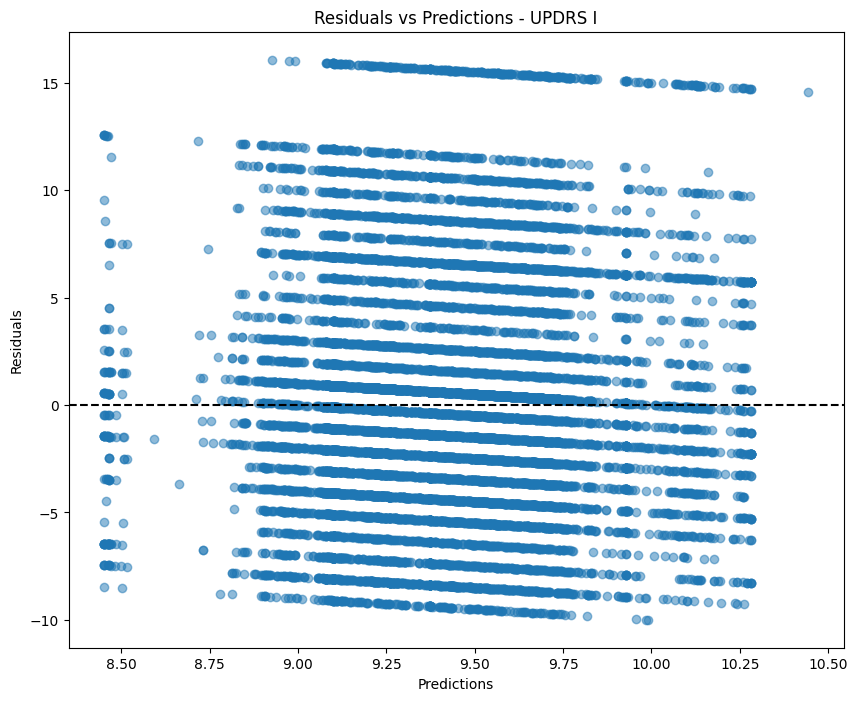

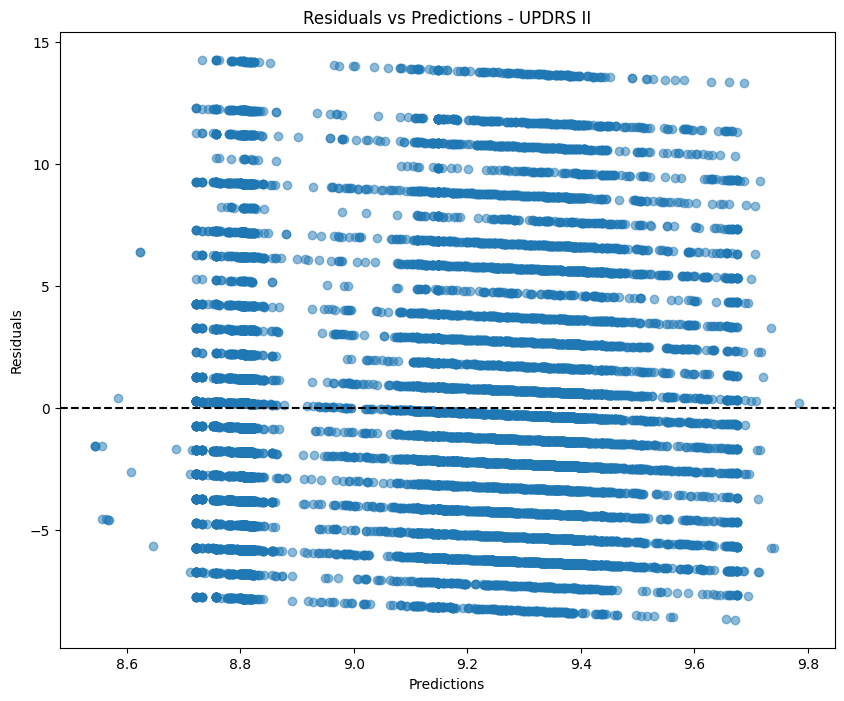

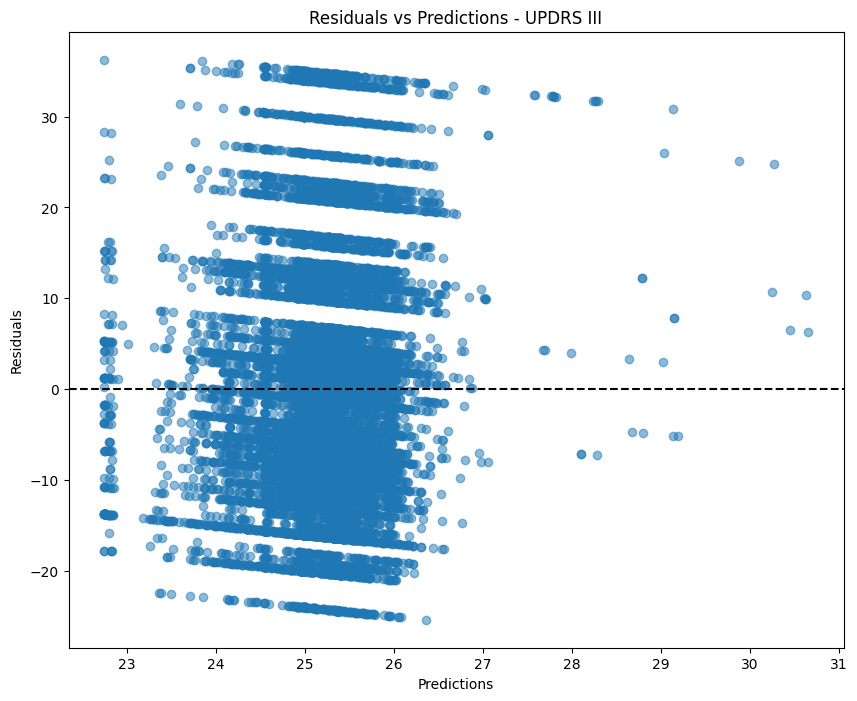

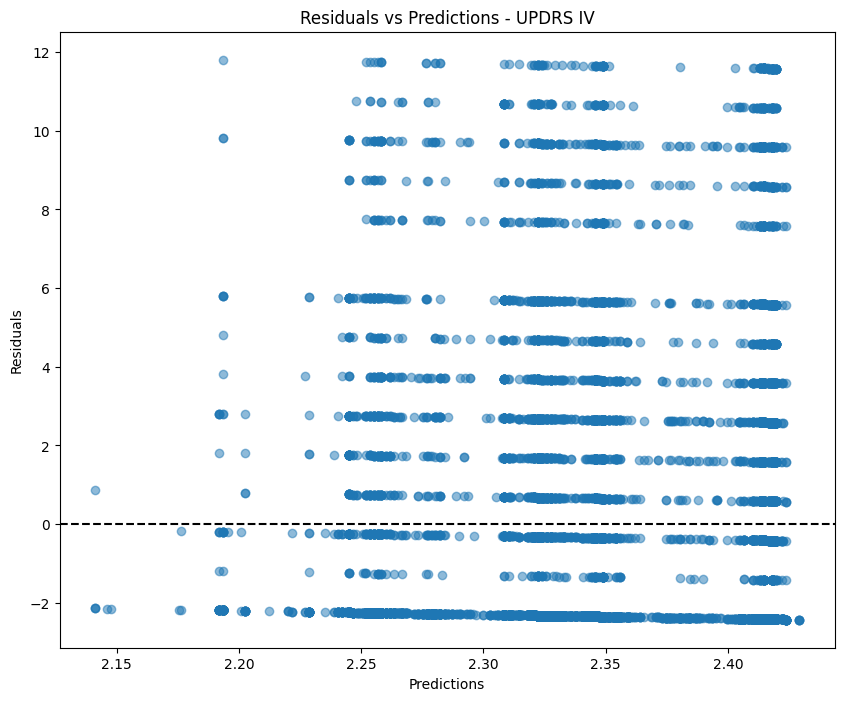

In [22]:
for i, data in enumerate(processed_data_para_predecir):
    y_pred = models[f'model_{i+1}'].predict(data['X_test'])
    residuos = data['y_test'] - y_pred

    plt.figure(figsize=(10, 8))
    plt.scatter(y_pred, residuos, alpha=0.5)
    plt.title(f"Residuals vs Predictions - {DICCIONARIO_UPDRS[HYPERPARAMETERS['modelos'][i]]}")
    plt.xlabel('Predictions')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.savefig(os.path.join(HYPERPARAMETERS['ruta_guardar_imagenes'], f"residuos_vs_predicciones_{DICCIONARIO_MODELOS[HYPERPARAMETERS['tipo_de_model']]}_{DICCIONARIO_UPDRS[HYPERPARAMETERS['modelos'][i]]}.png"))
    plt.show()


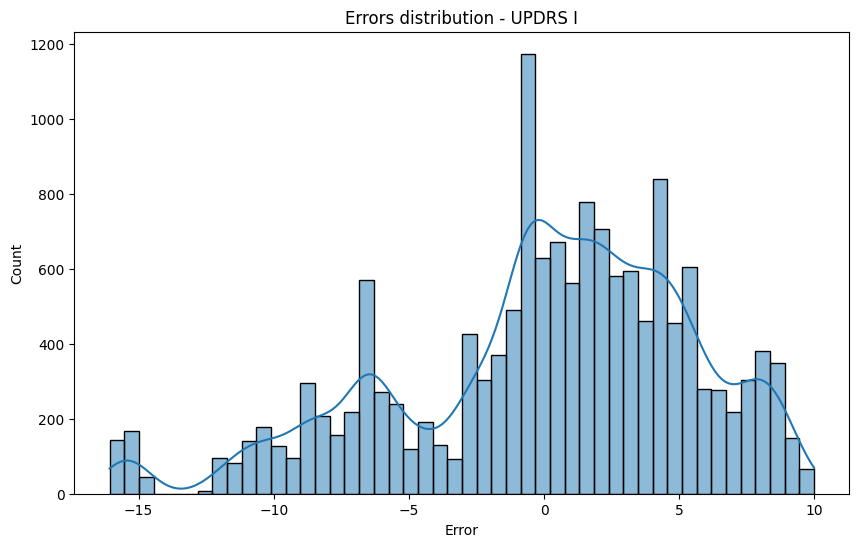

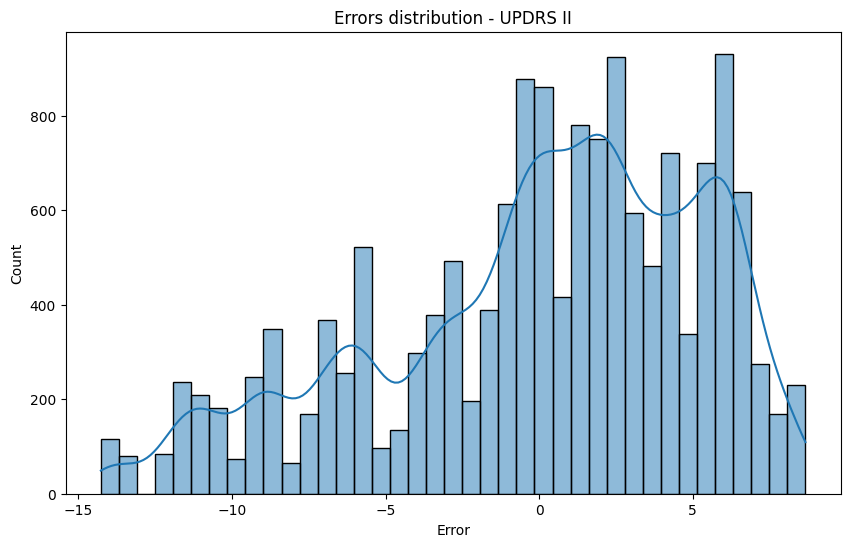

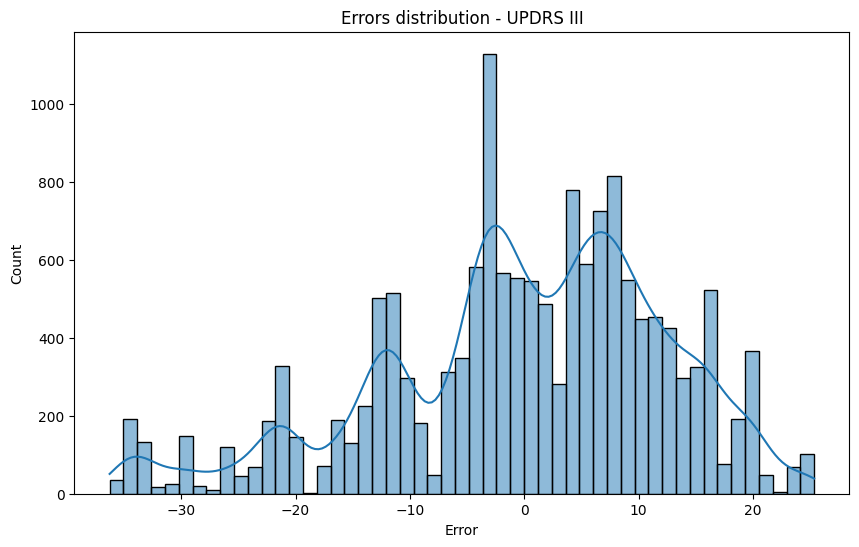

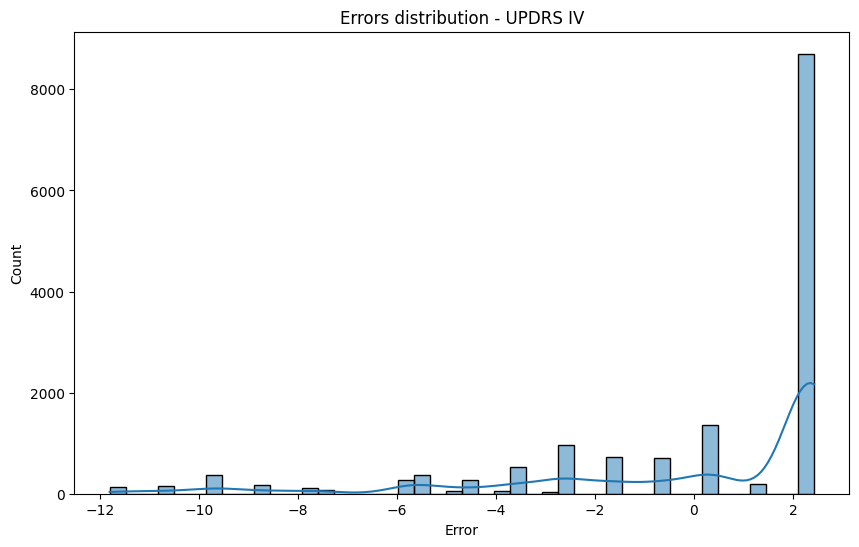

In [23]:
for i, data in enumerate(processed_data_para_predecir):
    y_pred = models[f'model_{i+1}'].predict(data['X_test'])
    errores = y_pred - data['y_test']
    
    plt.figure(figsize=(10, 6))
    sns.histplot(errores, kde=True)
    plt.title(f"Errors distribution - {DICCIONARIO_UPDRS[HYPERPARAMETERS['modelos'][i]]}")
    plt.xlabel('Error')
    plt.savefig(os.path.join(HYPERPARAMETERS['ruta_guardar_imagenes'], f"distribucion_de_errores_{DICCIONARIO_MODELOS[HYPERPARAMETERS['tipo_de_model']]}_{DICCIONARIO_UPDRS[HYPERPARAMETERS['modelos'][i]]}.png"))
    plt.show()

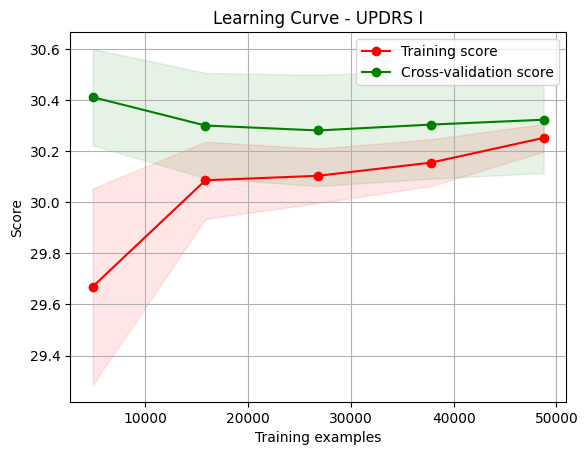

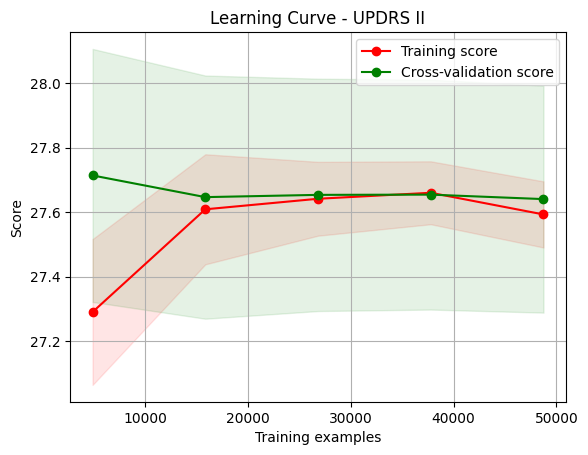

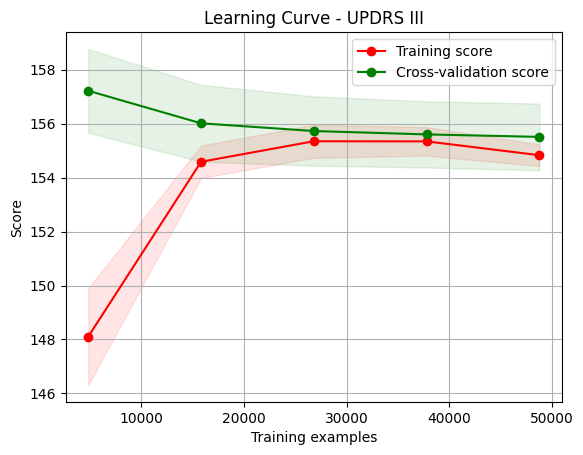

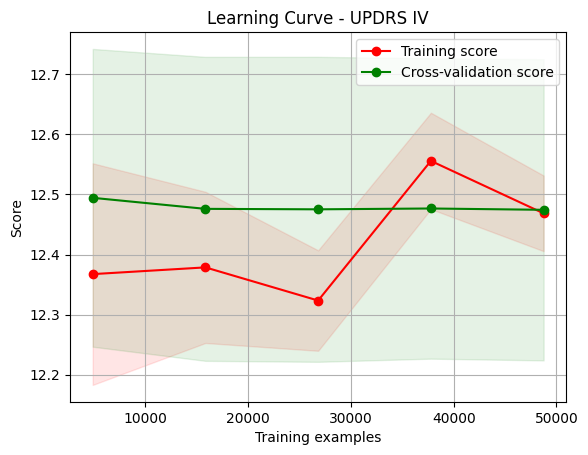

In [24]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="neg_mean_squared_error")
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for i, data in enumerate(processed_data_para_predecir):
    estimator = models[f'model_{i+1}']
    plot_learning_curve(estimator, f"Learning Curve - {DICCIONARIO_UPDRS[HYPERPARAMETERS['modelos'][i]]}", data['X_train'], data['y_train'], cv=cv, n_jobs=4)
    plt.savefig(os.path.join(HYPERPARAMETERS['ruta_guardar_imagenes'], f"learning_curve_{DICCIONARIO_MODELOS[HYPERPARAMETERS['tipo_de_model']]}_{DICCIONARIO_UPDRS[HYPERPARAMETERS['modelos'][i]]}.png"))
    plt.show()
